## Tanh and ReLU implementation

In [58]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
from graphviz import Digraph

def trace(root):
    nodes, edges= set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

In [60]:
def draw_dot(root):
    dot= Digraph(format='svg', graph_attr={'rankdir':'LR'})
    nodes, edges= trace(root)
    for n in nodes:
        uid= str(id(n))
        dot.node(name= uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name= uid + n._op, label= n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [107]:
# the real Big Deal !!
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data= data
        self.grad= 0.0
        self._prev= set(_children)
        self._op= _op
        self.label= label
        self._backward= lambda: None

    def __repr__(self):
        return f"Value(data= {self.data})"

    def __add__(self, other):
        out= Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad+= out.grad * 1.0
            other.grad+= out.grad * 1.0
        out._backward= _backward
        return out

    def __sub__(self, other):
        out= Value(self.data - other.data,(self,other),'-')
        def _backward():
            self.grad+= out.grad * 1.0
            other.grad-= out.grad * 1.0
        out._backward= _backward
        return out

    def __mul__(self, other):
        out= Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad+= out.grad * other.data
            other.grad+= out.grad * self.data
        out._backward= _backward
        return out

    def __pow__(self, exponent):
      out = Value(self.data ** exponent.data, (self, exponent), '**')
      def _backward():
          self.grad += out.grad * (exponent.data * self.data ** (exponent.data - 1.0))
          exponent.grad += out.grad * (self.data ** exponent.data * math.log(self.data))
      out._backward = _backward
      return out


    # Adding reverse dunder functions

    def __radd__(self,other):
      out= Value(self.data + other.data,(self,other),'+')
      def _backward():
        self.grad+= out.grad * 1.0
        other.grad+= out.grad * 1.0
      out._backward= _backward
      return out

    def __rmul__(self,other):
      out= Value(self.data * other.data,(self,other),'*')
      def _backward():
        self.grad+= out.grad * 1.0
        other.grad+= out.grad * 1.0
      out._backward= _backward
      return out

    def __rsub__(self,other):
      out= Value(other.data - self.data,(self,other),'-')
      def _backward():
        self.grad-= out.grad * 1.0
        other.grad+= out.grad * 1.0
      out._backward= _backward
      return out

    def tanh(self):
      x= self.data
      e= math.e
      t= (e**(2*x) - 1) / (e**(2*x) + 1)
      out= Value(t, (self,), 'tanh')
      def _backward():
        self.grad= out.grad * (1 - t**2)
      out._backward= _backward
      return out

    def ReLU(self):
      x = self.data
      if(x<=0):
        t = 0
      else:
        t=self.data
      out= Value(t, (self,), 'ReLU')
      def _backward():
        if(x<=0):
          self.grad= out.grad * (0)
        else:
          self.grad= out.grad * 1
      out._backward= _backward
      return out

    def backward(self):
        topo= []
        visited= set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad= 1
        for node in reversed(topo):
            node._backward()

# Tanh Activation function

In [108]:
x1= Value(2.0, label='x1')
x2= Value(0.0, label='x2')
w1= Value(-3.0, label='w1')
w2= Value(1.0, label='w2')
b= Value(6.8813735870195432, label='b')
x1w1= x1 * w1; x1w1.label= 'x1 * w1'
x2w2= x2 * w2; x2w2.label= 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1*w1 + x2*w2'
n= x1w1x2w2 + b; n.label= 'n'
o= n.tanh(); o.label= 'o';

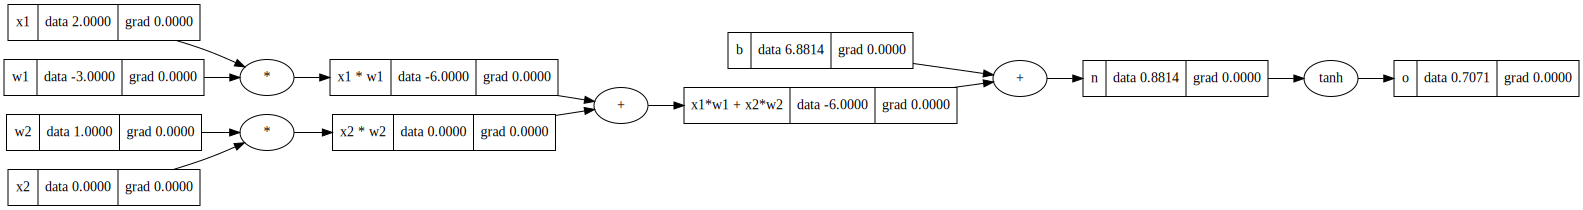

In [103]:
draw_dot(o)

# ReLU Activation Function

In [111]:

x1= Value(1, label='x1')
x2= Value(0, label='x2')

w11 = Value(3.0, label='w11')
w12 = Value(1.0, label='w12')

w21 = Value(2.5, label='w21')
w22 = Value(2.0, label='w22')

N1= (x1 * w11) + (x2 * w21)
N1.label= 'N1'

N2= (x1 * w12) + (x2 * w22)
N2.label= 'N2'

w3= Value(2.0, label='w3')
w4= Value(3.0, label='w4')

Fin = (N1 * w3) + (N2 * w4)
Fin.label= 'Fin'
Out= Fin.ReLU()
Out.label= 'Out';

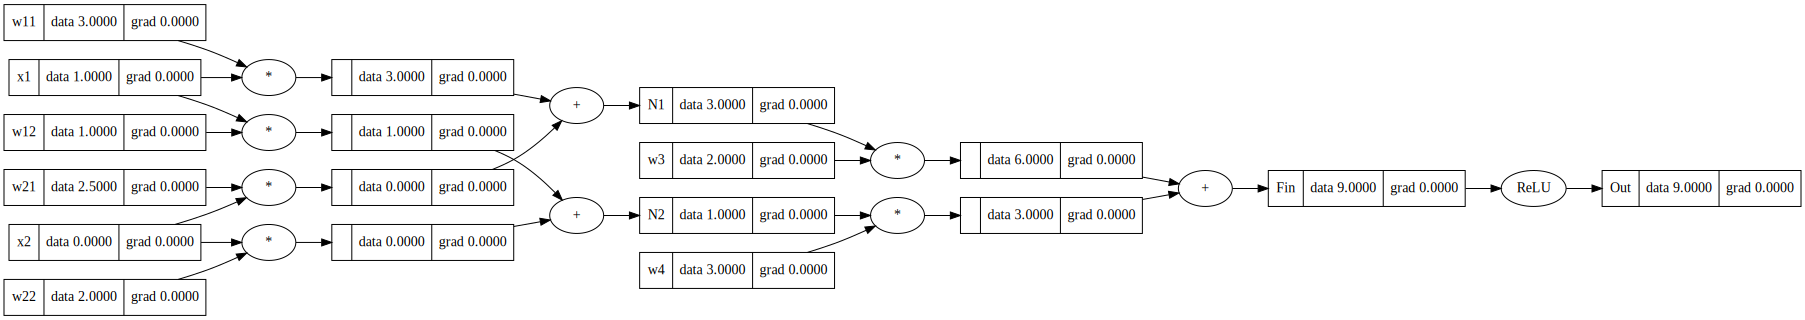

In [112]:
draw_dot(Out)